## Face Generation
<p>In this project we'll define and train a DCGAN on a Dataset of faces.Our goal is to get a generator network  to generate new images of faces that's look's as realastic as possible. we'll be using the CelebFaces Attributes Dataset (CelebA) to train  adversarial networks.</p>


In [0]:
from zipfile import ZipFile
with ZipFile('processed-celeba-small.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [0]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Load the Data

In [0]:
import torch
from torchvision import  datasets, transforms

In [0]:
def get_dataloader(batch_size, image_size, data_dir = 'processed_celeba_small/'):
  '''
  Batch the neural network data using DataLoader
  :param batch_size: The size of each batch; the number of images in a batch
  :param image_size: The squre size of the image data (x, y)
  :param data_dir: Directory where image data is located
  :return DataLoader with barched data
  '''
  transform=transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                               # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
  dataset = datasets.ImageFolder(data_dir, transform = transform)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
  return dataloader

## Create a DataLoader

In [0]:
# defining function hyperparameters
batch_size = 128
# size of training images
image_size = 64

# getting dataloader
celeba_train_loader = get_dataloader(batch_size, image_size)

## Visualize the celebA Data
we'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, 

In [0]:
# helper display function
def imshow(img):
  # converting Tenosr image to numpy for display
  npimg = img.numpy()
  # transposing the image dimensions to correctly display as image
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

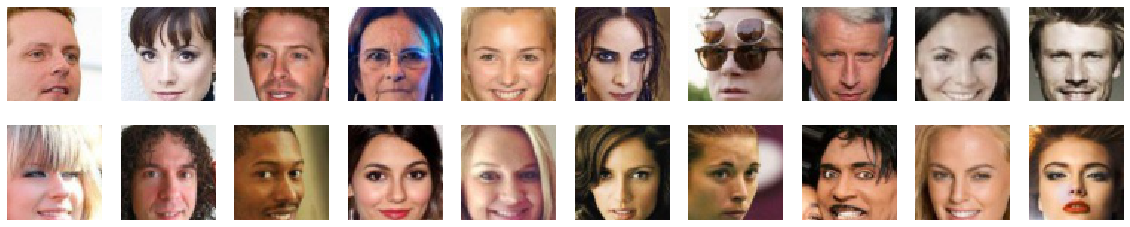

In [0]:
# obtaining one batch of training images
dataiter = iter(celeba_train_loader)
images, _  = dataiter.next() # -, for no labels

# plot the images in the batch
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks = [], yticks = [])
  imshow(images[idx])



## Pre-processing: scaling from -1 to 1
<p>we need to do a bit of preprocessing. we know that output of a tanh activated generator will contains pixel values in a range from -1 to 1. so we need to rescale our  training images in a range of - -1 to 1 (Right now they are in a range from 0  to 1)</p>



In [0]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(1.)


In [0]:
def scale(x, feature_range=(-1, 1)):
  '''
  scale takes an image x and returns that image scaled 
  with a feature_range of pixel values from -1 to 1
  This function assumes that input x is already scaled from 0-1
  '''
  min, max = feature_range
  x = x * (max - min) + min
  return x

In [0]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


## Defining the Model
<p>A GAN is compraised of two adversarial networks. a discriminator and a generator</p>


### Discriminator
**Defining Discriminator**
- The inputs to the discriminator are 64x64x3 tensor images

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm = True):
  '''
  creates a convlutional layer, with optional batch normalization
  '''
  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
  layers.append(conv_layer)
  
  if batch_norm:
    # append batchnorm layer
    layers.append(nn.BatchNorm2d(out_channels))
    
  return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
  def __init__(self, conv_dim):
    '''
    Initialize the Discriminator Module
    :param conv_dim: The deapth of first convlutional layer
    
    '''
    super(Discriminator, self).__init__()
    
    self.conv_dim = conv_dim
    
    # 64 x 64 input
    self.conv1 = conv(3, conv_dim, 4, batch_norm = False)
    # 32 x 32 out
    self.conv2 = conv(conv_dim, conv_dim * 2, 4)
    # 16 x 16 out
    self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
    # 8 x 8 out
    self.conv4 = conv(conv_dim * 4, conv_dim * 8, 4)
    # 4 x 4 out
    
    # final, fully connected layer
    self.fc = nn.Linear(conv_dim * 8 * 4 * 4, 1)
    
  def forward(self, x):
    '''
    Forward propagation of the neural network
    :param x: The input to the neural network
    :return: Discriminator logits, the ouput of the neural network
    
    '''
    # all hidden layers + leaky_relu activation
    out = F.leaky_relu(self.conv1(x), 0.2)
    out = F.leaky_relu(self.conv2(out), 0.2)
    out = F.leaky_relu(self.conv3(out), 0.2)
    out = F.leaky_relu(self.conv4(out), 0.2)
    
    # flatten
    out = out.view(-1, self.conv_dim * 8 * 4 * 4)
    # final output layer
    out = self.fc(out)
    
    return out
    
    
  

### Generator
The Generator should upsample an input and generte new images of the same size as our training data 64 x 64 x 3.This will be mostly transpose convlutuinal layers with normalization applied to outputs.


In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm = True):
  '''
  creates a transposed convlutional layer with optional batch normalization.
  '''
  layers = []
  transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                            kernel_size, stride, padding, bias = False)
  layers.append(transpose_conv_layer)
  
  if batch_norm:
    # append batchnormalization
    layers.append(nn.BatchNorm2d(out_channels))
    
  return nn.Sequential(*layers)
  
  

In [0]:
class Generator(nn.Module):
  def __init__(self, z_size, conv_dim):
    '''
    Initializes the Generator Module
    :param z_size: The length of the input latent vector z
    :param conv_dim: The depth of the inpus to the  **last** transpose convlutional layer
    
    '''
    super(Generator, self).__init__()
    
    self.conv_dim = conv_dim
    
    # first fully connected layer
    self.fc = nn.Linear(z_size, conv_dim * 8 * 4 * 4)
    
    # transpose conv layers
    self.t_conv1 = deconv(conv_dim * 8, conv_dim * 4, 4)
    self.t_conv2 = deconv(conv_dim * 4, conv_dim * 2, 4)
    self.t_conv3 = deconv(conv_dim * 2, conv_dim, 4)
    self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm = False)
    
  def forward(self, x):
    
    '''
    forward propagation of the neural network
    :param x: The input to the neural network
    :return: A 32x32x3 Tensor image as input
    '''
    out = self.fc(x)
    out = out.view(-1, self.conv_dim * 8, 4, 4)
    
    # hidden transpose conv layers + relu
    out = F.relu(self.t_conv1(out))
    out = F.relu(self.t_conv2(out))
    out = F.relu(self.t_conv3(out))
    
    # last layer + tanh activation
    out = self.t_conv4(out)
    out = torch.tanh(out)
        
    return out
    


## Intializing weights of network

In [0]:
def weights_init_normal(m):
  '''
  Applies intial weights to certain layers in a model
  The weights are taken from a normal distribution
  with mean = 0, std_dev = 0.02
  :param m: A module or layer in a network
  
  '''
  # classname will be something like:
  # `Conv`, `BatchNorm2d`, `Linear`, etc.
  classname = m.__class__.__name__
  # Applying intial eights to convlutional and linear layers
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  if classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  # The bias terms, if they exist, set to 0
  if hasattr(m, 'bias') and m.bias is not None:
    m.bias.data.zero_()
 

## Build Complete Network


In [0]:
def build_network(d_conv_dim, g_conv_dim, z_size):
  # define Discriminator and Generator
  D = Discriminator(d_conv_dim)
  G = Generator(z_size = z_size, conv_dim = g_conv_dim)
  # intialize model weigths 
  D.apply(weights_init_normal)
  G.apply(weights_init_normal)
  
  print(D)
  print()
  print(G)
  
  return D, G

In [0]:
# Define model hyperparams

# size of feature maps in Discriminator
d_conv_dim = 64
# size of feature maps in Generator
g_conv_dim = 64
z_size = 100


D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fal

## Test for CUDA

In [0]:
import torch

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print('CUDA is Available! Training on GPU.......')
else:
  print('No GPU found. Please use a GPU to train your neural network.')

CUDA is Available! Training on GPU.......


## Discriminator and Generator Losses
<p>Now we need to calculate losses for both types of afversarial networks</p>
**Discriminator Losses**
- For  the discriminator, total loss is the sum of the losses of real and fake images. d_loss = d_real_loss + d_fake_loss
- we want discriminator output to 1 for real images and 0 for fake imges, so we need to set up the losses to reflect that.<br>
** Generator loss **
<p>Generator loss will look similar only with flipped labels. The generator's  goal is to get the discriminator to think gennerated images are real!</p>


In [0]:
def real_loss(D_out, smooth = False):
  '''
  Calculates how close Discriminator outputs are to being real.
  :param D_out: Discriminator logits
  :retun: real_loss
  '''
  # Getting batch_size
  batch_size = D_out.size(0)
  # label smoothing
  if smooth:
    # smooth, real labels = 0.9
    labels = torch.ones(batch_size) * 0.9
  else:
    labels = torch.ones(batch_size) # real labels = 1
  
  # move labels to GPU, if CUDA is Available
  if train_on_gpu:
    labels = labels.cuda()
  # Binary cross entropy loss with logits loss
  criterion = nn.BCEWithLogitsLoss()
  # calcualte loss
  loss = criterion(D_out.squeeze(), labels)
  
  return loss

def fake_loss(D_out):
  '''
  Calculate how close Discriminator ouputs are to being fake.
  :param D_out: Discriminator logits
  :return: fake loss
  '''
  # getting batch_size
  batch_size = D_out.size(0)
  # fake labels = 0
  labels = torch.zeros(batch_size)
  # move labels to GPU if CUDA is Available
  if train_on_gpu:
    labels = labels.cuda()
  
  # Binary cross entropy loss with logits loss
  criterion = nn.BCEWithLogitsLoss()
  # calculate loss
  loss = criterion(D_out.squeeze(), labels)
  
  return loss

## Defiing Optimizers for Discriminator and Generator

In [0]:
import torch.optim as optim

# setting hyerparameters for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 # default value

d_optimizer = optim.Adam(D.parameters(), lr, betas = (beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr, betas = (beta1, beta2))

## Training
Training will invlove alternating between  training  the discriminator and the generator. we use functions real_loss and fake loss to calculate Discriminator losses.
- we should train the discriminator by alternating on real and fake images.
- Then the generator which tries to trick the Discriminator and should have an opposing loss function


In [0]:
def train(D, G, n_epochs, print_every = 50):
  '''
  Train adversarial networks for some number of epochs
  param, D: the Discriminator network
  param, G: the Generator network
  param, n_epochs: number of epochs to train for
  param, print_every: when to record and print model losses
  return:  D and G losses
  '''
  # move models to GPU if CUDA is Available
  if train_on_gpu:
    D.cuda()
    G.cuda()
    
  # keep track of loss and generated, 'fake' samples
  samples = []
  losses = []
  # Get some fixed data for sampling. These are images that are held constant throught 
  # training. and allows us to inspect the model performence
  sample_size = 16
  fixed_z = np.random.uniform(-1, 1, size = (sample_size, z_size))
  fixed_z = torch.from_numpy(fixed_z).float()
  
  # move z to GPU if CUDA is Available
  if train_on_gpu:
    fixed_z = fixed_z.cuda()
  
  # epoch training loop
  for epoch in range(n_epochs):
    # batch training loop
    for batch_i, (real_images, _) in enumerate(celeba_train_loader):
      batch_size = real_images.size(0)
      real_images = scale(real_images)
      
      ###########################
      # Train the Discriminator #
      ############################
      d_optimizer.zero_grad()
      
      # 1. Train with real images
      # computing discriminator loss on real images
      
      # move images to GPU, if CUDA is Available
      if train_on_gpu:
        real_images = real_images.cuda()
      
      D_real = D(real_images)
      d_real_loss = real_loss(D_real)
      
      # 2. Train with fake images
      # Generate fake images
      z = np.random.uniform(-1, 1, size = (batch_size, z_size))
      z = torch.from_numpy(z).float()
      # move z to GPU, if CUDA is Available
      if train_on_gpu:
        z = z.cuda()
      fake_images = G(z)
      
      # computing discriminator loss on fake images
      D_fake = D(fake_images)
      d_fake_loss = fake_loss(D_fake)
      
      # add up loss and perform backprop
      d_loss = d_real_loss + d_fake_loss
      d_loss.backward()
      d_optimizer.step()
      
      ########################
      # Train the Generator #
      ########################
      g_optimizer.zero_grad()
      
      # 1. Train the fake images with flipped labels
      # Generate fake images
      z = np.random.uniform(-1, 1, size = (batch_size, z_size))
      z = torch.from_numpy(z).float()
      
      # move z to GPU if CUDA Available
      if train_on_gpu:
        z = z.cuda()
      
      fake_images = G(z)
      # Compute the discriminator losses on fake images 
      # using flipped labels!
      D_fake = D(fake_images)
      g_loss = real_loss(D_fake)
      
      # performing backprop
      g_loss.backward()
      g_optimizer.step()
      
      # Print some loss stats
      if batch_i % print_every == 0:
        # append discriminator loss and generator loss
        losses.append((d_loss.item(), g_loss.item()))
        # print discriminator and generator loss
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
            epoch+1, n_epochs, d_loss.item(), g_loss.item()))
      
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode
    
    
  # Save training generator samples
  with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
    
  # finally return losses
  return losses
 

 Setting number of epochs and training GAN!

In [0]:
# number of epcohs to train the model
n_epochs = 10

# calling Training Function
losses = train(D, G, n_epochs = n_epochs)

Epoch [    1/   10] | d_loss: 1.3697 | g_loss: 1.7281
Epoch [    1/   10] | d_loss: 0.0233 | g_loss: 7.0847
Epoch [    1/   10] | d_loss: 0.3217 | g_loss: 4.3384
Epoch [    1/   10] | d_loss: 0.3632 | g_loss: 3.4948
Epoch [    1/   10] | d_loss: 0.5143 | g_loss: 5.6597
Epoch [    1/   10] | d_loss: 0.3799 | g_loss: 3.0829
Epoch [    1/   10] | d_loss: 0.4502 | g_loss: 3.2827
Epoch [    1/   10] | d_loss: 1.5439 | g_loss: 1.2902
Epoch [    1/   10] | d_loss: 0.6426 | g_loss: 1.7151
Epoch [    1/   10] | d_loss: 1.0922 | g_loss: 5.1595
Epoch [    1/   10] | d_loss: 0.5586 | g_loss: 2.6059
Epoch [    1/   10] | d_loss: 0.3762 | g_loss: 2.6175
Epoch [    1/   10] | d_loss: 0.5483 | g_loss: 2.3830
Epoch [    1/   10] | d_loss: 0.6595 | g_loss: 2.0111
Epoch [    1/   10] | d_loss: 0.6279 | g_loss: 1.5226
Epoch [    2/   10] | d_loss: 0.7317 | g_loss: 1.7913
Epoch [    2/   10] | d_loss: 0.7426 | g_loss: 3.5292
Epoch [    2/   10] | d_loss: 0.6160 | g_loss: 1.9350
Epoch [    2/   10] | d_loss

## Training losses
plotting training losses for Discriminator and generator recorded after each epoch.


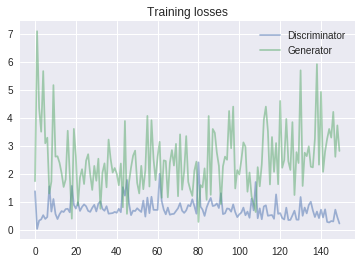

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label = 'Discriminator', alpha = 0.5)
plt.plot(losses.T[1], label = 'Generator', alpha = 0.5)
plt.title('Training losses')
plt.legend();

## Generator Samples from Training
View sample of images from the generator

In [0]:
# helper function for viewing list of passed in sample images
def view_samples(epoch, samples):
  fig, axes = plt.subplots(figsize = (16, 4), nrows = 2, ncols = 8, sharex = True, sharey = True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = ((img + 1) * 255 / (2)).astype(np.uint8)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((64,64,3)))

In [0]:
# Load samples from Generator, taken while Training
with open('train_samples.pkl', 'rb') as f:
  samples = pkl.load(f)

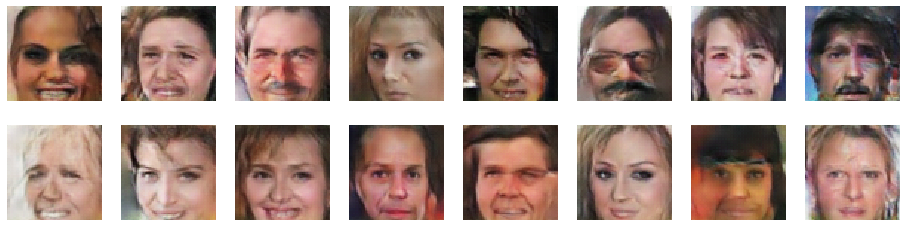

In [0]:
# -1 indicates final epoch's samples (the last in the list)
_ = view_samples(-1, samples)